# 🧬 Conway's Game of Life: Analysis & Benchmarking

This notebook provides a comprehensive analysis of Conway's Game of Life, featuring:
1. **Visualization**: A pure Python implementation to demonstrate specific patterns like the **Glider** and **Glider Gun**.
2. **Integration**: Wrappers to compile and run the optimized C implementations (Sequential & Pthreads).
3. **High-Performance Benchmarking**: Automated stress testing on high-core-count CPUs (Xeon 20-thread test).

In [1]:
import os
import sys
import re
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setup plotting style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# --- WORKING DIRECTORY SETUP ---
if os.path.basename(os.getcwd()) == 'tools':
    os.chdir('..')
    print(f"Moved working directory to project root: {os.getcwd()}")
else:
    print(f"Current working directory: {os.getcwd()}")

# Define paths
BIN_DIR = "bin"
SAMPLES_DIR = "samples"
SEQ_EXE = os.path.join(BIN_DIR, "game_of_life_seq")
PAR_EXE = os.path.join(BIN_DIR, "game_of_life_pthread")

os.makedirs(SAMPLES_DIR, exist_ok=True)

Moved working directory to project root: /home/fc/Documents/github/parallel-computing/project-2-game-of-life-pthreads


## 1️⃣ Part 1: Visualizing the Logic

We use a pure Python implementation to verify the rules and visualize standard patterns.

In [2]:
def python_step(grid):
    """
    Pure Python/NumPy implementation of one Game of Life step.
    Uses circular boundary conditions (toroidal) via np.roll.
    """
    neighbors = (
        np.roll(grid, 1, 0) + np.roll(grid, -1, 0) +
        np.roll(grid, 1, 1) + np.roll(grid, -1, 1) +
        np.roll(np.roll(grid, 1, 0), 1, 1) +
        np.roll(np.roll(grid, 1, 0), -1, 1) +
        np.roll(np.roll(grid, -1, 0), 1, 1) +
        np.roll(np.roll(grid, -1, 0), -1, 1)
    )
    
    new_grid = np.zeros_like(grid)
    new_grid[(grid == 1) & ((neighbors == 2) | (neighbors == 3))] = 1
    new_grid[(grid == 0) & (neighbors == 3)] = 1
    return new_grid

def create_glider(rows=10, cols=10):
    """Creates a grid with a single Glider at the top-left."""
    grid = np.zeros((rows, cols), dtype=int)
    # Standard Glider pattern
    coords = [(0,1), (1,2), (2,0), (2,1), (2,2)]
    for r, c in coords:
        grid[r, c] = 1
    return grid

def create_gun(rows=50, cols=50):
    """Creates a grid with a Gosper Glider Gun."""
    grid = np.zeros((rows, cols), dtype=int)
    gun_coords = [
        (5,1),(5,2),(6,1),(6,2),
        (3,13),(3,14),(4,12),(4,16),(5,11),(5,17),(6,11),(6,15),(6,17),(6,18),
        (7,11),(7,17),(8,12),(8,16),(9,13),(9,14),
        (1,25),(2,23),(2,25),(3,21),(3,22),(4,21),(4,22),(5,21),(5,22),
        (6,23),(6,25),(7,25),
        (3,35),(3,36),(4,35),(4,36)
    ]
    for r, c in gun_coords:
        if r < rows and c < cols:
            grid[r, c] = 1
    return grid

### **Visualizing the Glider Pattern**

A **Glider** is the smallest and most common "spaceship" in the Game of Life. It consists of 5 live cells that oscillate through 4 distinct phases.

**Behavior:**
* It travels diagonally across the grid.
* It repeats its shape every 4 generations, shifted by one cell diagonally.
* Below, we observe the cycle from **Generation 0** to **Generation 8** (two full cycles).

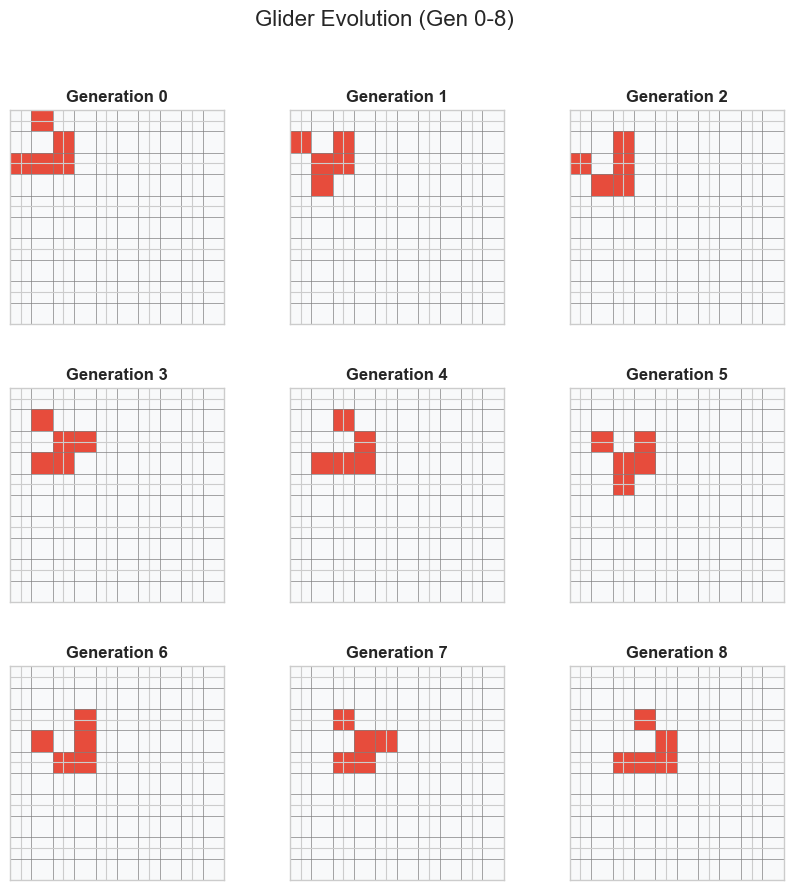

In [3]:
# Setup Glider Grid
rows, cols = 10, 10
glider_grid = create_glider(rows, cols)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

cmap = ListedColormap(['#f8f9fa', '#e74c3c'])

# Simulate and Plot 9 frames (Gen 0 to Gen 8)
current = glider_grid.copy()
for i, ax in enumerate(axes):
    # Plot current state
    ax.imshow(current, cmap=cmap, interpolation='nearest')
    ax.set_title(f"Generation {i}", fontweight='bold')
    
    # Add gridlines for clarity
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Step forward
    current = python_step(current)

plt.suptitle("Glider Evolution (Gen 0-8)", fontsize=16)
plt.show()

### **Visualizing Complex Patterns (Gosper Glider Gun)**

The Glider Gun is a pattern that periodically produces gliders.

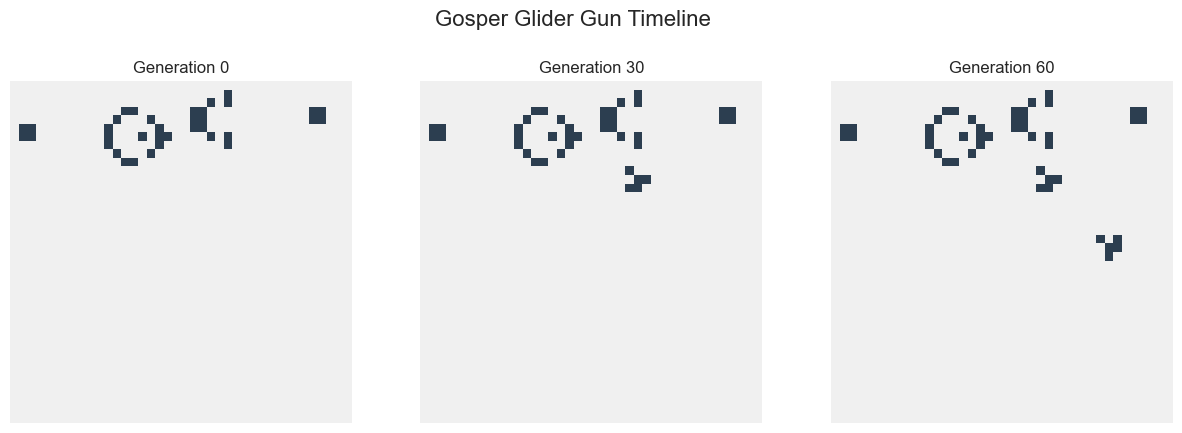

In [5]:
rows, cols = 40, 40
gun_grid = create_gun(rows, cols)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cmap = ListedColormap(['#f0f0f0', '#2c3e50'])

checkpoints = [0, 30, 60]
current = gun_grid.copy()
current_gen = 0

for ax, target_gen in zip(axes, checkpoints):
    # Advance to target generation
    while current_gen < target_gen:
        current = python_step(current)
        current_gen += 1
        
    ax.imshow(current, cmap=cmap, interpolation='nearest')
    ax.set_title(f"Generation {target_gen}")
    ax.grid(False)
    ax.axis('off')

plt.suptitle("Gosper Glider Gun Timeline", fontsize=16)
plt.show()

## 2️⃣ Part 2: C Compilation

Compiling the project to ensure binaries are fresh.

In [6]:
print("🔨 Compiling C project...")
try:
    subprocess.run(["make", "clean"], check=True, stdout=subprocess.DEVNULL)
    subprocess.run(["make", "sequential"], check=True, stdout=subprocess.PIPE)
    subprocess.run(["make", "parallel"], check=True, stdout=subprocess.PIPE)
    print("✅ Build successful.")
except subprocess.CalledProcessError as e:
    print(f"❌ Compilation failed: {e}")

🔨 Compiling C project...
✅ Build successful.


In [7]:
# Benchmark Helpers
def parse_c_output(stdout_str):
    time_match = re.search(r"Execution time:\s+([0-9\.]+)\s+seconds", stdout_str)
    mem_match = re.search(r"Peak memory:\s+([0-9]+)\s+KB", stdout_str)
    return (float(time_match.group(1)) if time_match else None, 
            int(mem_match.group(1)) if mem_match else None)

def generate_input_file(filename, rows, cols, generations, density=0.2):
    filepath = os.path.join(SAMPLES_DIR, filename)
    total = rows * cols
    alive = int(total * density)
    rng = np.random.default_rng()
    indices = rng.choice(total, alive, replace=False)
    rows_idx, cols_idx = np.unravel_index(indices, (rows, cols))
    
    with open(filepath, 'w') as f:
        f.write(f"{generations}\n{rows} {cols}\n{alive}\n")
        for r, c in zip(rows_idx, cols_idx):
            f.write(f"{r} {c}\n")
    return filepath

def run_benchmark(executable, input_file, threads=None):
    cmd = [executable, input_file]
    if threads: cmd.append(str(threads))
    try:
        res = subprocess.run(cmd, capture_output=True, text=True, check=True)
        return parse_c_output(res.stdout)
    except: return None, None

## 3️⃣ Part 3: High-Thread Benchmarking (Xeon Scale)

We configured the test for a **10-core / 20-thread Xeon** processor.

**Thread Strategy:**
* **1-10 Threads:** Testing scaling within physical cores.
* **11-20 Threads:** Testing SMT (Hyperthreading) efficiency.
* **21-40 Threads:** Testing oversubscription/context-switching overhead.

In [8]:
# --- HIGH THREAD CONFIGURATION ---
GRID_SIZES = [2000, 5000]  # Large grids to justify many threads
# 1, 2, 4, 8, 10 (Physical), 16, 20 (SMT max), 32, 40 (Oversubscribed)
THREAD_COUNTS = [1, 2, 4, 8, 10, 16, 20, 32, 40]
GENERATIONS = 50
DENSITY = 0.2

results = []
print(f"🚀 Starting High-Thread Benchmark (Generations: {GENERATIONS})...")
print(f"{'Size':<8} | {'Type':<6} | {'Threads':<8} | {'Time (s)':<10} | {'Mem (MB)':<10}")
print("-" * 55)

for size in GRID_SIZES:
    fname = f"bench_xeon_{size}x{size}.txt"
    input_path = generate_input_file(fname, size, size, GENERATIONS, DENSITY)
    
    # Baseline Sequential
    seq_time, seq_mem = run_benchmark(SEQ_EXE, input_path)
    if seq_time:
        print(f"{size:<8} | {'Seq':<6} | {'1':<8} | {seq_time:<10.4f} | {seq_mem/1024:<10.1f}")
        results.append({'Size': size, 'Type': 'Sequential', 'Threads': 1, 
                        'Time': seq_time, 'Speedup': 1.0})
    
    # Threaded Runs
    for t in THREAD_COUNTS:
        par_time, par_mem = run_benchmark(PAR_EXE, input_path, threads=t)
        if par_time and seq_time:
            speedup = seq_time / par_time
            print(f"{size:<8} | {'Par':<6} | {t:<8} | {par_time:<10.4f} | {par_mem/1024:<10.1f}")
            results.append({'Size': size, 'Type': 'Parallel', 'Threads': t, 
                            'Time': par_time, 'Speedup': speedup})

df = pd.DataFrame(results)

🚀 Starting High-Thread Benchmark (Generations: 50)...
Size     | Type   | Threads  | Time (s)   | Mem (MB)  
-------------------------------------------------------
2000     | Seq    | 1        | 16.8364    | 185.3     
2000     | Par    | 1        | 16.9957    | 185.3     
2000     | Par    | 2        | 8.8812     | 185.3     
2000     | Par    | 4        | 4.6203     | 185.3     
2000     | Par    | 8        | 2.4235     | 185.3     
2000     | Par    | 10       | 1.9704     | 185.3     
2000     | Par    | 16       | 2.1461     | 185.3     
2000     | Par    | 20       | 1.9171     | 185.3     
2000     | Par    | 32       | 1.9186     | 185.3     
2000     | Par    | 40       | 1.8804     | 185.3     
5000     | Seq    | 1        | 104.9325   | 396.0     
5000     | Par    | 1        | 104.6300   | 396.0     
5000     | Par    | 2        | 54.2316    | 396.0     
5000     | Par    | 4        | 28.5959    | 396.0     
5000     | Par    | 8        | 14.4484    | 396.0     
5000     |

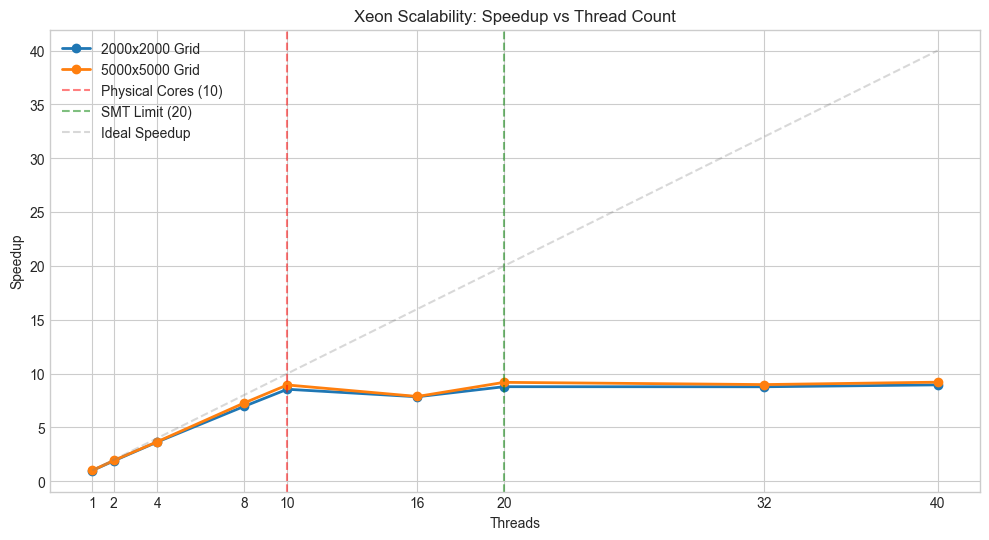

In [9]:
# --- XEON SCALING PLOT ---
plt.figure(figsize=(12, 6))
par_df = df[df["Type"] == "Parallel"]

for size in GRID_SIZES:
    subset = par_df[par_df["Size"] == size]
    plt.plot(subset["Threads"], subset["Speedup"], marker='o', linewidth=2, label=f"{size}x{size} Grid")

# Reference Lines
plt.axvline(x=10, color='r', linestyle='--', alpha=0.5, label="Physical Cores (10)")
plt.axvline(x=20, color='g', linestyle='--', alpha=0.5, label="SMT Limit (20)")
plt.plot(THREAD_COUNTS, THREAD_COUNTS, '--', color='gray', alpha=0.3, label="Ideal Speedup")

plt.title("Xeon Scalability: Speedup vs Thread Count")
plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.legend()
plt.xticks(THREAD_COUNTS)
plt.show()

### 📊 Benchmark Summary Table

In [12]:
# Display a clean summary table sorted by Size and Efficiency
summary = df[['Size', 'Type', 'Threads', 'Time', 'Speedup']].sort_values(['Size', 'Threads'])
summary.style.background_gradient(subset=['Speedup'], cmap='Greens').format({
    'Time': '{:.4f}',
    'Speedup': '{:.2f}',
    'Memory_MB': '{:.1f}'
})

,Size,Type,Threads,Time,Speedup
0,2000,Sequential,1,16.8364,1.00
1,2000,Parallel,1,16.9957,0.99
2,2000,Parallel,2,8.8812,1.90
3,2000,Parallel,4,4.6203,3.64
4,2000,Parallel,8,2.4235,6.95
5,2000,Parallel,10,1.9704,8.54
6,2000,Parallel,16,2.1461,7.85
7,2000,Parallel,20,1.9171,8.78
8,2000,Parallel,32,1.9186,8.78
9,2000,Parallel,40,1.8804,8.95
